We use the data used in the analysis reported on in (Jego et al, 2022)

In [1]:
import APEX as ap
import pyccl as ccl
import numpy as np
import sacc as sc
import time

cosmo = ccl.Cosmology(
    Omega_c=0.261,
    Omega_b=0.049,
    h=0.677,
    n_s=0.9665,
    sigma8=0.8102,
    #transfer_function="bbks",
    #matter_power_spectrum="halofit")
)

import warnings

# The warning message to ignore
warning_message = "The FITS format without the 'sacc_ordering' column is deprecated."

# Apply the filter to ignore this specific UserWarning
warnings.filterwarnings("ignore", message=warning_message, category=UserWarning)

# ... the rest of your code that uses the sacc library

One should check the layout of the sacc file first:

In [2]:
sacc_data = sc.Sacc.load_fits('cls_cov_minimal_newcov.fits')

#print all tracers
print("Tracer combinations:", sacc_data.get_tracer_combinations())

Tracer combinations: [(np.str_('CIBLenz__0'), np.str_('eBOSSQSO__0')), (np.str_('CIBLenz__0'), np.str_('eBOSSQSO__1')), (np.str_('CIBLenz__1'), np.str_('eBOSSQSO__0')), (np.str_('CIBLenz__1'), np.str_('eBOSSQSO__1')), (np.str_('CIBLenz__2'), np.str_('eBOSSQSO__0')), (np.str_('CIBLenz__2'), np.str_('eBOSSQSO__1')), (np.str_('DELS__0'), np.str_('CIBLenz__0')), (np.str_('DELS__0'), np.str_('CIBLenz__1')), (np.str_('DELS__0'), np.str_('CIBLenz__2')), (np.str_('DELS__0'), np.str_('DELS__0')), (np.str_('DELS__1'), np.str_('CIBLenz__0')), (np.str_('DELS__1'), np.str_('CIBLenz__1')), (np.str_('DELS__1'), np.str_('CIBLenz__2')), (np.str_('DELS__1'), np.str_('DELS__1')), (np.str_('DELS__2'), np.str_('CIBLenz__0')), (np.str_('DELS__2'), np.str_('CIBLenz__1')), (np.str_('DELS__2'), np.str_('CIBLenz__2')), (np.str_('DELS__2'), np.str_('DELS__2')), (np.str_('DELS__3'), np.str_('CIBLenz__0')), (np.str_('DELS__3'), np.str_('CIBLenz__1')), (np.str_('DELS__3'), np.str_('CIBLenz__2')), (np.str_('DELS__3'

In [3]:
t = sacc_data.tracers['CIBLenz__2']

In [4]:
gd_file = 'cls_cov_minimal_newcov.fits'

cib_snu_file = 'filtered_snu_planck.fits'

In [5]:
gdwsp = ap.GalaxyDensityTracerWorkspace(
    sacc_file=gd_file,
    tracer_name_root="DELS__",
    max_index=3,
    cosmology=cosmo
)

cibwsp = ap.CIBIntensityTracerWorkspace(
    flux_fits_file=cib_snu_file,
    cosmology=cosmo,
    tracer_name_root="CIBLenz__",
    single_index=2
)

tracer_combos = [('DELS__0', 'DELS__0'),
                 ('DELS__1', 'DELS__1'),
                 ('DELS__2', 'DELS__2'),
                 ('DELS__3', 'DELS__3'),
                 ('DELS__0', 'CIBLenz__2'),
                 ('DELS__1', 'CIBLenz__2'),
                 ('DELS__2', 'CIBLenz__2'),
                 ('DELS__3', 'CIBLenz__2'),
                ]

s = ap.SaccWorkspace(gd_file, tracer_combinations=tracer_combos)


In [6]:
cibwsp.define_tracer_objects()

cibwsp.tracers_obj[0].get_beam_window()

In [11]:
mmodel = ap.MaleubreModel(
    Tracer1Workspace=gdwsp,
    Tracer2Workspace=cibwsp,
    tracer_combos=tracer_combos,
    sacc_workspace=s,
    cosmology=cosmo,
    logged_N=True,
    k_max = 0.2
)

In [8]:
elapsed_times = []

for i in range(0,50):

    start_time = time.perf_counter()
    mmodel.lightweight_log_likelihood_function(b_gs=np.array([0.962442, 1.128193, 1.306405, 1.655859]),
        N_ggs=np.array([-7.11044, -9.346793, -9.893426, -8.653993]),
        A_ggs=np.array([4.841672, 8.002266, 11.706755, 27.02337]),
        N_gnus=np.array([-12.057331, -12.250513, -12.754224, -11.944748]),
        A_gnus=np.array([0.543653, 0.905731, 1.101477, 0.665272]),
        bpsfrs=np.array([0.018771, 0.051464, 0.089074, 0.135279]),)
    end_time = time.perf_counter()

    elapsed_time = end_time - start_time
    elapsed_times.append(elapsed_time)

np.mean(elapsed_times)

np.float64(0.15979776215999664)

In [12]:
mcmc = ap.MCMCWorkspace(
    model=mmodel,
    likelihood_function='lightweight_log_likelihood_function',
    sacc_file=gd_file

)

params = ['b_g0', 'b_g1', 'b_g2', 'b_g3',
          'N_gg0', 'N_gg1', 'N_gg2', 'N_gg3',
          'A_gg0', 'A_gg1', 'A_gg2', 'A_gg3',
          'N_gnu0', 'N_gnu1', 'N_gnu2', 'N_gnu3',
          'A_gnu0', 'A_gnu1', 'A_gnu2', 'A_gnu3',
          'bpsfr0', 'bpsfr1', 'bpsfr2', 'bpsfr3']
mcmc.set_param_priors(
    params=params,
    priors=[
        (0, 4), (0, 4), (0, 4), (0, 4),
        (-12, -4), (-12, -4), (-12, -4), (-12, -4),
        (-100, 100), (-100, 100), (-100, 100), (-100, 100),
        (-15, -8), (-15, -8), (-15, -8), (-15, -8),
        (-100, 100), (-100, 100), (-100, 100), (-100, 100),
        (0, 1), (0, 1), (0, 1), (0, 1),
    ]
)

mcmc.set_param_references(
    params=params,
    references=[
        0.8, 0.9, 1.2, 1.5,
        -8, -8, -8, -8,
        7, 7, 7, 7,
        -12, -12, -12, -12,
        7, 7, 7, 7,
        0.059, 0.11, 0.15, 0.18,
    ]
)

mcmc.set_param_proposals(
    params=params,
    proposals=[
        0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1,
        1, 1, 1, 1,
        0.1, 0.1, 0.1, 0.1,
        1, 1, 1, 1,
        0.003, 0.003, 0.003, 0.003,
    ]
)

mcmc.set_grouped_params({
    'b_gs': ['b_g0', 'b_g1', 'b_g2', 'b_g3'],
    'N_ggs': ['N_gg0', 'N_gg1', 'N_gg2', 'N_gg3'],
    'A_ggs': ['A_gg0', 'A_gg1', 'A_gg2', 'A_gg3'],
    'N_gnus': ['N_gnu0', 'N_gnu1', 'N_gnu2', 'N_gnu3'],
    'A_gnus': ['A_gnu0', 'A_gnu1', 'A_gnu2', 'A_gnu3'],    
    'bpsfrs': ['bpsfr0', 'bpsfr1', 'bpsfr2', 'bpsfr3']
})

mcmc.MCMC_config(params, sampler_info={'minimize': {'seed':42}})

sampler = mcmc.minimize_run()


[<bound method maleubremodel.lightweight_log_likelihood_function of <apex.maleubremodel object at 0x7fe46edf0690>>] Initialized external likelihood.
[minimize] *WARNING* This run has been SEEDED with seed 42
[minimize] Initializing
[minimize] Run 1/2 will start from random initial point:
[minimize] {'b_g0': np.float64(0.8), 'b_g1': np.float64(0.9), 'b_g2': np.float64(1.2), 'b_g3': np.float64(1.5), 'N_gg0': np.float64(-8.0), 'N_gg1': np.float64(-8.0), 'N_gg2': np.float64(-8.0), 'N_gg3': np.float64(-8.0), 'A_gg0': np.float64(7.0), 'A_gg1': np.float64(7.0), 'A_gg2': np.float64(7.0), 'A_gg3': np.float64(7.0), 'N_gnu0': np.float64(-12.0), 'N_gnu1': np.float64(-12.0), 'N_gnu2': np.float64(-12.0), 'N_gnu3': np.float64(-12.0), 'A_gnu0': np.float64(7.0), 'A_gnu1': np.float64(7.0), 'A_gnu2': np.float64(7.0), 'A_gnu3': np.float64(7.0), 'bpsfr0': np.float64(0.059), 'bpsfr1': np.float64(0.11), 'bpsfr2': np.float64(0.15), 'bpsfr3': np.float64(0.18)}
[minimize] Run 2/2 will start from random initial 

[  14.5   44.5   74.5  104.5  134.5  164.5  194.5  224.5  255.5  290.
  329.5  374.   424.5  482.   547.   621.   705.   800.5  909.  1032.
 1172.  1331.  1511.5 1716.5 1949.  2213.  2513.  2853.5 3240.  3679.5
 4178.5 4745.  5388.5 5937. ]
5936.999999999957 164.50000000000009
5936.999999999957 290.00000000000017
5936.999999999957 373.9999999999998
5936.999999999957 481.9999999999998
3
5936.999999999957 164.50000000000009
[2.65496221e-06 5.41330659e-10 2.86426952e-10 1.43791350e-09]
5936.999999999957 290.00000000000017
[3.90648049e-07 6.43720631e-10 2.36876520e-10 9.41211190e-10]
5936.999999999957 373.9999999999998
[1.22797312e-06 1.59926179e-09 2.45153672e-10]
5936.999999999957 481.9999999999998
[3.61912453e-10 7.45988072e-10]
3


/home/nathand/Documents/AstroCode/APEX/Examples/Plots.py:72: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  ax_main.plot(measured_data[0][i][~masks[i]], modelled_data[1][i][~masks[i]], 'k.', zorder=0, markersize=2,  color='C1')


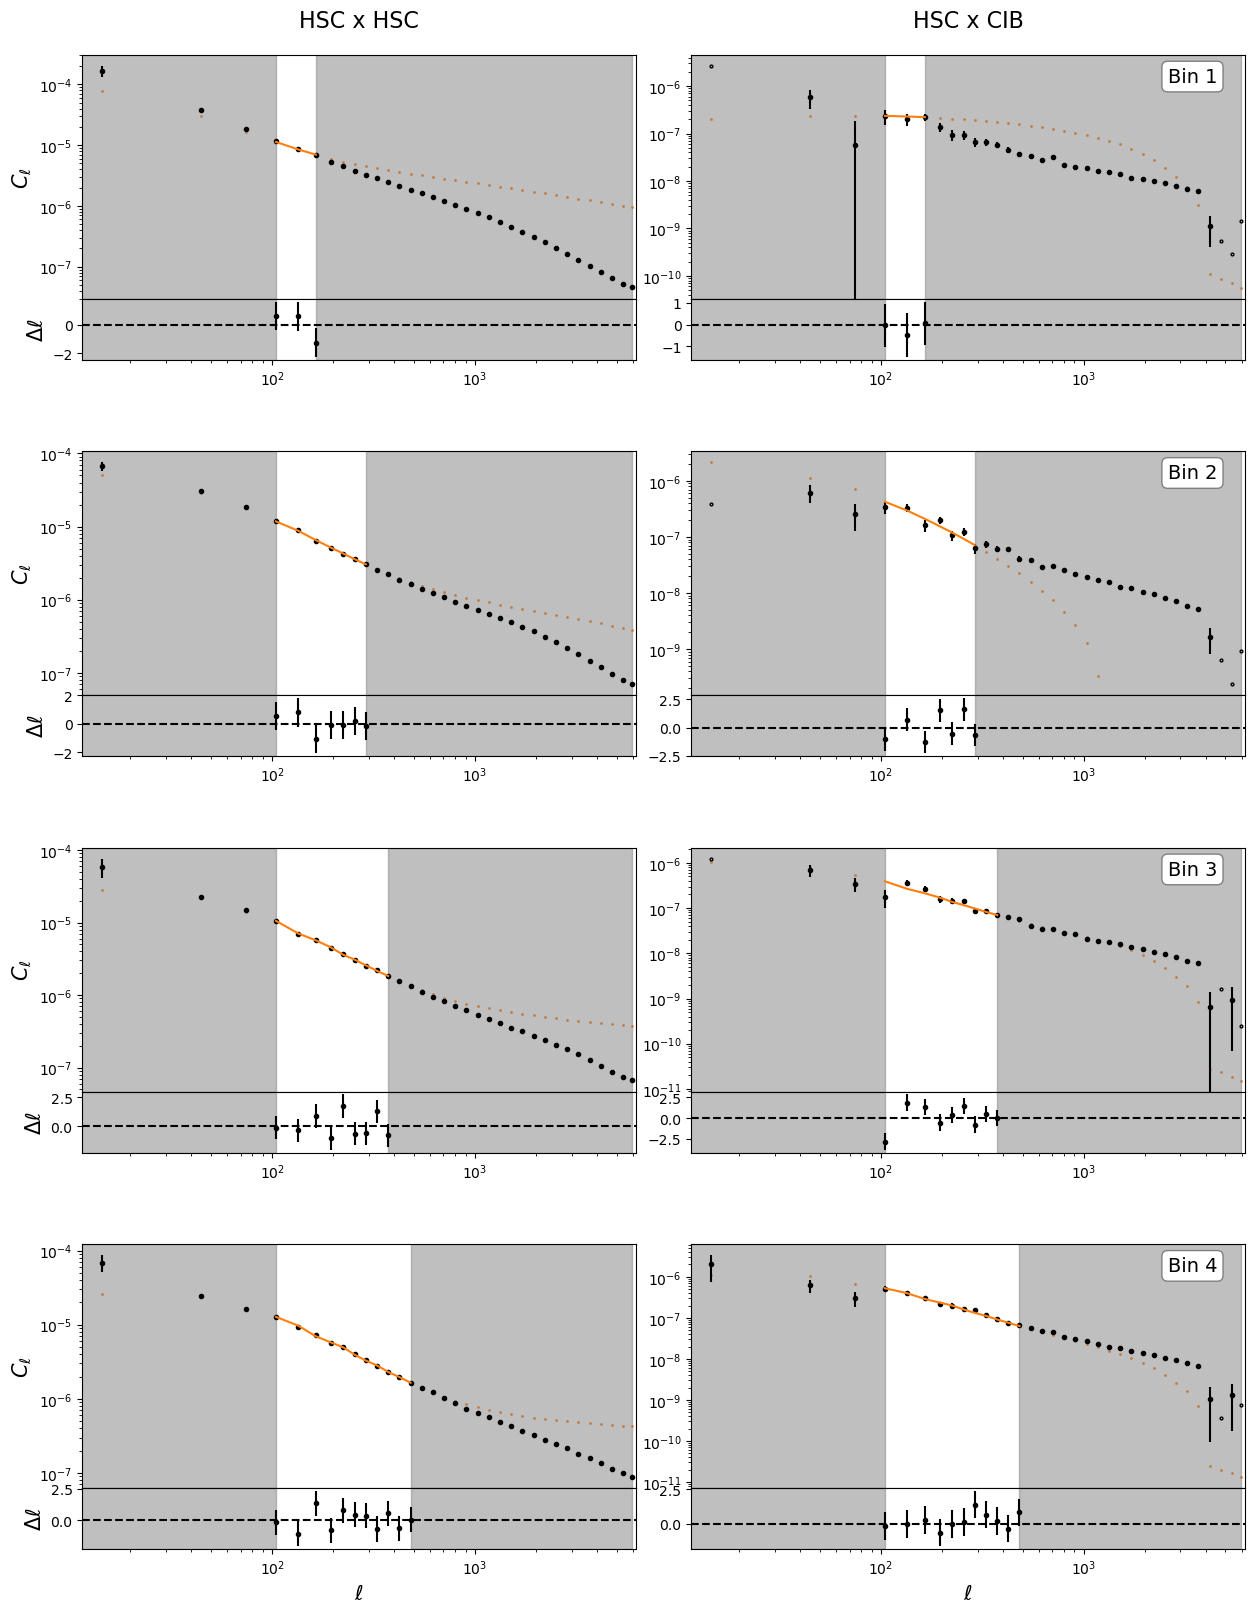

In [13]:
modelled = mmodel.get_modelled_data(
    b_gs=np.array([1.004507, 1.341324, 1.283832, 1.7074]),
    N_ggs=np.array([-7.02677, -8.528276, -6.720165, -6.522797]),
    A_ggs=np.array([22.722313, 23.746717, 14.902293, 16.732473]),
    N_gnus=np.array([-14.749662, -11.21555, -13.669225, -12.529115]),
    A_gnus=np.array([0.577466, -0.058384, 0.787226, 1.023365]),
    bpsfrs=np.array([0.000116, 0.036482, 0.040232, 0.055912]),
    full_ells=True
)

measured_data = s.get_c_ells(tracer_combos)

errors = s.get_errors(tracer_combos)

print(measured_data[0][0])

plotter = ap.Plots(s)

plotter.create_grid_plot(
    subplot_titles=['HSC x HSC', 'HSC x CIB'],
    subplot_tracer_combos=tracer_combos,
    measured_data=measured_data,
    measured_data_err=errors,
    modelled_data=modelled,
    cut_positions=[None, None],
    residuals=True,
    full_ells=True,
    variable_cuts=True
)